<a href="https://colab.research.google.com/github/couldbelauracampbell/DMA_team_assignment/blob/main/CA683_Project_Group_28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing Librarys to read in and explore data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
import os
import datetime
import time
import glob
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn import preprocessing
import seaborn as sns
import scipy
from scipy import stats
from statsmodels.compat import lzip
import statsmodels.formula.api as sm
import statsmodels.stats.stattools as st
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.api import add_constant
import re
pd.options.mode.chained_assignment = None
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


## Data Preparation

**Step 1:** Compile all files into a single data frame and add basetimestamp as a column

In [ ]:
from pathlib import Path
path = f"/drive/MyDrive/DMA_Assignment/Meat_Plant_Data/Data_collected/WIBS_Data/" 

# get all files from there
csv_pattern = os.path.join(path,'*.csv')
file_list = glob.glob(csv_pattern)

#  an empty list to store the data frames
dfs = []
for file in sorted(file_list):
     # read data frame from file
    data = pd.read_csv(file, header=1, skiprows=36)
    # add column header into column by reset index
    data = data.stack().reset_index()
    # Making first row of data the new column headers
    headers = data.iloc[0]
    df  = pd.DataFrame(data.values[1:], columns=headers)
    # Changing name of column 20
    df.rename(columns={ df.columns[20]: "start_time_stamp" }, inplace = True)
    # append the data frame to the list
    dfs.append(df)
#  merges single pandas DFs into a single DF, index is refreshed 
df = pd.concat(dfs, ignore_index=True)


In [ ]:
# Code to isolate the start date and time

## Function isolates the datetime substring from larger string and converts to date time
def timestamp(datestring):
  start_datetime = re.search(r'(\d+/\d+/\d+ \d+:\d+:\d+)', datestring)
  start_datetime=start_datetime.group()
  date_format = "%m/%d/%Y %H:%M:%S"
  datetime_object = datetime.strptime(start_datetime, date_format)
  datetime_object = datetime_object.strftime("%m:%d:%Y:%H:%M:%S:%f")
  return datetime_object

df.start_time_stamp = df.start_time_stamp.apply(timestamp)


# Converting the time  column into Datetime format
def ms_to_hms(milliseconds):
    # 1 hour = 3600000 milliseconds
    hours = milliseconds // 3600000
    # 1 minute = 60000 milliseconds
    minutes = (milliseconds % 3600000) // 60000
    # 1 second = 1000 milliseconds
    seconds = ((milliseconds % 3600000) % 60000) // 1000
    # remaining milliseconds
    ms = ((milliseconds % 3600000) % 60000) % 1000
    return (hours, minutes, seconds, ms)

hoursMinSec = ms_to_hms(22240)
date_format = "%m/%d/%Y %H:%M:%S:%b"

#Convert time column to int 
df.Time= df.Time.astype(int)
df.Time= df.Time.apply(ms_to_hms)

def convert_millisecond_tuple_to_datetime(t): #t = tuple
    # Convert the tuple to a pandas timestamp object the date here is arbitrary
    ts = pd.Timestamp(year=1900, month=1, day=1, hour=t[0], minute=t[1], second=t[2], microsecond=t[3]*1000)
    # Convert the timestamp object to a datetime object in format "%H:%M:%S:%f"
    dt = ts.strftime("%H:%M:%S:%f")
    return dt

timestamp = convert_millisecond_tuple_to_datetime(hoursMinSec)
df.Time = df.Time.apply(convert_millisecond_tuple_to_datetime)

## Get Time column as an interval
def getInterval(interval_string):
  interval_format = '%H:%M:%S:%f'
  interval = datetime.strptime(interval_string, interval_format) - datetime(1900, 1, 1) 
  return interval

df.Time= df.Time.apply(getInterval)


In [ ]:


#Convert the string to datetime
def convert_string_datetime(string):
  datetime_obj = datetime.strptime(string, "%m:%d:%Y:%H:%M:%S:%f")
  return datetime_obj

df.start_time_stamp = df.start_time_stamp.apply(convert_string_datetime)

def add_datetime_to_timedelta(dt, td):
  result = dt + td
  return result
df["Time_Series_Values"] = df.apply(lambda row: add_datetime_to_timedelta(row['start_time_stamp'], row['Time']), axis=1)
df["Time_Series_Values"] = pd.to_datetime(df["Time_Series_Values"])
df['Date'] = df["Time_Series_Values"].dt.date
df['Day'] = df["Time_Series_Values"].dt.day_name()
df['Time'] = df["Time_Series_Values"].dt.time
df['Hour'] = df["Time_Series_Values"].dt.hour
df["Timestamp"] = df["Time_Series_Values"]


# **Creating 3 dataframes:**


1.   **df_full**: will be our full dataset
2.   **df_nonwork**: filtered to non working time
1.   **df_work**: filtered for working times 




In [ ]:
df_full = df
df_nonwork = df
df_work = df

For df_work we remove Saturday, Sunday and wash times

In [ ]:
# Remove weekend for df_work
df_work = df_work[(df_work['Day'] != 'Saturday') & (df_work['Day'] !='Sunday') ]

In [ ]:
# df_work
import datetime

# Filter the data to specific MMP working hours
start_hour = datetime.time(6, 0, 0)  
end_hour = datetime.time(23, 59, 59)   

# Attempt to parse 'Time' column with the expected format, and set errors='coerce' to handle unmatched formats
df_work['Time'] = pd.to_datetime(df_work['Time'], format='%H:%M:%S.%f', errors='coerce')

# Drop rows with NaT values in the 'Time' column
df_work = df_work.dropna(subset=['Time'])

# Convert the 'Time' column to datetime.time objects
df_work['Time'] = df_work['Time'].dt.time

# Filter the DataFrame based on specific working hours
df_work = df_work[(df_work['Time'].apply(lambda x: x >= start_hour and x <= end_hour))]

For df_nonwork we create a seperate dataframe df_nonwork_weekday to store the weekdays and filter to the wash times only. Then we create a df_nonwork_weekend to just capture Saturday and Sunday data. We the concat the 2 dataframes to give us our non working times dataframe

In [ ]:
df_nonwork_weekday = df_nonwork[(df_nonwork['Day'] != 'Saturday') & (df_nonwork['Day'] !='Sunday') ]
df_nonwork_weekday['Day'].unique()

array(['Thursday', 'Friday', 'Tuesday', 'Wednesday', 'Monday'],
      dtype=object)

In [ ]:
# df_nonwork_weekday 
import datetime

# Filter the data to specific MMP working hours
start_hour = datetime.time(0, 0, 0)  
end_hour = datetime.time(6, 0, 0)   

# Attempt to parse 'Time' column with the expected format, and set errors='coerce' to handle unmatched formats
df_nonwork_weekday ['Time'] = pd.to_datetime(df_nonwork_weekday ['Time'], format='%H:%M:%S.%f', errors='coerce')

# Drop rows with NaT values in the 'Time' column
df_nonwork_weekday  = df_nonwork_weekday .dropna(subset=['Time'])

# Convert the 'Time' column to datetime.time objects
df_nonwork_weekday ['Time'] = df_nonwork_weekday ['Time'].dt.time

# Filter the DataFrame based on specific working hours
df_nonwork_weekday  = df_nonwork_weekday [(df_nonwork_weekday ['Time'].apply(lambda x: x >= start_hour and x <= end_hour))]

In [ ]:
df_nonwork_weekend = df_nonwork[(df_nonwork['Day'] != 'Monday') & (df_nonwork['Day'] !='Tuesday') & (df_nonwork['Day'] !='Wednesday') & (df_nonwork['Day'] !='Thursday') & (df_nonwork['Day'] !='Friday') ]
df_nonwork_weekend['Day'].unique()

array(['Saturday', 'Sunday'], dtype=object)

In [ ]:
df_nonwork = pd.concat([df_nonwork_weekend, df_nonwork_weekday], ignore_index=True)
print(df_nonwork)

0                   Time FL2 SctInt Scat_EL1 Scat_EL2 Scat_EL3 Scat_EL4  \
0        10:51:57.025000        277        0        9        6        9   
1        10:51:57.232000        174        1        9        6        8   
2        10:51:57.416000        258        0       16       13       15   
3        10:51:57.492000        257        0       15        9       14   
4        10:51:57.504000        238        1       14       10       12   
...                  ...        ...      ...      ...      ...      ...   
1069564  05:03:56.571000        217        1        6        6        7   
1069565  05:11:17.399000        236        1        7        3        7   
1069566  05:11:30.239000        216        1        7        6        8   
1069567  05:54:11.377000        171        1        2        2        1   
1069568  05:56:04.009000        244        1       17       13       16   

0       FL2 SctPk FL1_280 FL2_280 Pwr_280  ... MeasT2 FT TPCT1  \
0              28      24      15

We index our timestamp for all dataframes

In [ ]:
df_full["Time_Series_Values"] = pd.to_datetime(df_full["Time_Series_Values"])
# Index timestamp and order by timestamp
df_full = df_full.sort_values(by="Time_Series_Values")
df_full.set_index("Time_Series_Values", inplace=True)


In [ ]:
df_work ["Time_Series_Values"] = pd.to_datetime(df_work ["Time_Series_Values"])
# Index timestamp and order by timestamp
df_work  = df_work .sort_values(by="Time_Series_Values")
df_work .set_index("Time_Series_Values", inplace=True)

In [ ]:
df_nonwork ["Time_Series_Values"] = pd.to_datetime(df_nonwork ["Time_Series_Values"])
# Index timestamp and order by timestamp
df_nonwork  = df_nonwork .sort_values(by="Time_Series_Values")
df_nonwork .set_index("Time_Series_Values", inplace=True)

**Step 2:** Remove secondary data used for monitoring performance issues of the machine

In [ ]:
df_full.drop(['FL2 SctInt', 'Scat_EL1', 'Scat_EL2', 'Scat_EL3', 'Scat_EL4','FL2 SctPk', 'Pwr_280', 'Pwr_370','TOF', 'TPCT2',  'TotalT2', 'MeasT2', 'FT', 'TPCT1', 'TotalT1','start_time_stamp'], axis=1, inplace=True) 
df_work.drop(['FL2 SctInt', 'Scat_EL1', 'Scat_EL2', 'Scat_EL3', 'Scat_EL4','FL2 SctPk', 'Pwr_280', 'Pwr_370','TOF', 'TPCT2',  'TotalT2', 'MeasT2', 'FT', 'TPCT1', 'TotalT1','start_time_stamp'], axis=1, inplace=True) 
df_nonwork.drop(['FL2 SctInt', 'Scat_EL1', 'Scat_EL2', 'Scat_EL3', 'Scat_EL4','FL2 SctPk', 'Pwr_280', 'Pwr_370','TOF', 'TPCT2',  'TotalT2', 'MeasT2', 'FT', 'TPCT1', 'TotalT1','start_time_stamp'], axis=1, inplace=True) 

**Step 3:** Remove non- fluorescent particles using the force trigger data file to create thresholds

In [ ]:
path = f"/drive/MyDrive/DMA_Assignment/Forced_Trigger_0000.csv"
df_ft = pd.read_csv(path, sep=",")
df_ft.head()

,Time,FL2 SctInt,Scat_EL1,Scat_EL2,Scat_EL3,Scat_EL4,FL2 SctPk,FL1_280,FL2_280,Pwr_280,...,Pwr_370,TOF,TPCT2,Size,AF,TotalT2,MeasT2,FT,TPCT1,TotalT1
0,705,4,2,1,2,0,0,48,8,572,...,801,0,1,0.0,-1,4.4,3.8,3,0,4.592
1,1409,2,0,1,4,3,0,12,10,580,...,807,0,1,0.0,-1,3.4,2.8,3,0,3.526
2,2115,4,0,0,1,1,0,62,7,589,...,805,0,1,0.0,-1,2.2,1.8,3,0,2.329
3,2819,6,1,0,5,3,0,53,5,569,...,793,0,1,0.0,-1,1.8,1.4,3,0,1.809
4,3525,4,1,1,4,0,0,13,6,585,...,813,0,1,0.0,-1,0.8,0.8,3,0,1.119


In [ ]:
#Calculate and create the mean varaible for Forced Trigger Data
FL1_280_mean = np.mean(df_ft["FL1_280"])
FL2_280_mean = np.mean(df_ft["FL2_280"])
FL2_370_mean = np.mean(df_ft["FL2_370"])

print('Mean of FL1_280: ',FL1_280_mean)
print('Mean of FL2_280: ',FL2_280_mean)
print('Mean of FL2_370: ',FL2_370_mean)

Mean of FL1_280:  43.89116342545206
Mean of FL2_280:  8.326168543159332
Mean of FL2_370:  13.823609689525759


In [ ]:
#Calculate and create the standard deviation varaible for Forced Trigger Data
FL1_280_std_dev = np.std(df_ft["FL1_280"])
FL2_280_std_dev = np.std(df_ft["FL2_280"])
FL2_370_std_dev = np.std(df_ft["FL2_370"])
print('Standard Deviation of FL1_280: ',FL1_280_std_dev)
print('Standard Deviation of FL2_280: ',FL2_280_std_dev)
print('Standard Deviation of FL2_370: ',FL2_370_std_dev)

Standard Deviation of FL1_280:  21.686519113728675
Standard Deviation of FL2_280:  2.3696436031860717
Standard Deviation of FL2_370:  4.012850656175729


Will create Threshold - 9 times the standard deviation as per N.J Savage paper

In [ ]:
#Calculate the threshold (mean + 9sd)
Threshold_2_FL1_280 = (FL1_280_mean + (9*FL1_280_std_dev))
Threshold_2_FL2_280 = (FL2_280_mean + (9*FL2_280_std_dev))
Threshold_2_FL2_370 = (FL2_370_mean + (9*FL2_370_std_dev))

print('Threshold_2_FL1_280: ',Threshold_2_FL1_280)
print('Threshold_2_FL2_280: ',Threshold_2_FL2_280)
print('Threshold_2_FL2_370: ',Threshold_2_FL2_370)

Threshold_2_FL1_280:  239.06983544901016
Threshold_2_FL2_280:  29.652960971833977
Threshold_2_FL2_370:  49.93926559510732


In [ ]:
# Convert variables and thresholds to numeric
df_full['FL1_280'] = pd.to_numeric(df_full['FL1_280'])
df_full['FL2_280'] = pd.to_numeric(df_full['FL2_280'])
df_full['FL2_370'] = pd.to_numeric(df_full['FL2_370'])

df_work['FL1_280'] = pd.to_numeric(df_work['FL1_280'])
df_work['FL2_280'] = pd.to_numeric(df_work['FL2_280'])
df_work['FL2_370'] = pd.to_numeric(df_work['FL2_370'])

df_nonwork['FL1_280'] = pd.to_numeric(df_nonwork['FL1_280'])
df_nonwork['FL2_280'] = pd.to_numeric(df_nonwork['FL2_280'])
df_nonwork['FL2_370'] = pd.to_numeric(df_nonwork['FL2_370'])


Threshold_2_FL1_280 = pd.to_numeric(Threshold_2_FL1_280)
Threshold_2_FL2_280 = pd.to_numeric(Threshold_2_FL2_280)
Threshold_2_FL2_370 = pd.to_numeric(Threshold_2_FL2_370)

**Step 4**: Applying WIBS Channel Annotation - Florescent categories


In [ ]:
# THRESHOLD to df_full and categorise to WIBS Channel Annotation

# Conditions List
conditions = [
    (df_full["FL1_280"] > Threshold_2_FL1_280) & (df_full["FL2_280"] < Threshold_2_FL2_280) & (df_full["FL2_370"] < Threshold_2_FL2_370),
    (df_full["FL1_280"] < Threshold_2_FL1_280) & (df_full["FL2_280"] > Threshold_2_FL2_280) & (df_full["FL2_370"] < Threshold_2_FL2_370),
    (df_full["FL1_280"] < Threshold_2_FL1_280) & (df_full["FL2_280"] < Threshold_2_FL2_280) & (df_full["FL2_370"] > Threshold_2_FL2_370),
    (df_full["FL1_280"] > Threshold_2_FL1_280) & (df_full["FL2_280"] < Threshold_2_FL2_280) & (df_full["FL2_370"] > Threshold_2_FL2_370),
    (df_full["FL1_280"] > Threshold_2_FL1_280) & (df_full["FL2_280"] > Threshold_2_FL2_280) & (df_full["FL2_370"] < Threshold_2_FL2_370),
    (df_full["FL1_280"] < Threshold_2_FL1_280) & (df_full["FL2_280"] > Threshold_2_FL2_280) & (df_full["FL2_370"] > Threshold_2_FL2_370),
    (df_full["FL1_280"] > Threshold_2_FL1_280) & (df_full["FL2_280"] > Threshold_2_FL2_280) & (df_full["FL2_370"] > Threshold_2_FL2_370)
    ]

# Values of conditions
values = ['A', 'B', 'C', 'AC','AB','BC','ABC']

# Values assigned to dataframe based on conditions
df_full['WIBS Channel Annotation'] = np.select(conditions, values)

# THRESHOLD to df_work and categorise to WIBS Channel Annotation

# Conditions List
conditions = [
    (df_work["FL1_280"] > Threshold_2_FL1_280) & (df_work["FL2_280"] < Threshold_2_FL2_280) & (df_work["FL2_370"] < Threshold_2_FL2_370),
    (df_work["FL1_280"] < Threshold_2_FL1_280) & (df_work["FL2_280"] > Threshold_2_FL2_280) & (df_work["FL2_370"] < Threshold_2_FL2_370),
    (df_work["FL1_280"] < Threshold_2_FL1_280) & (df_work["FL2_280"] < Threshold_2_FL2_280) & (df_work["FL2_370"] > Threshold_2_FL2_370),
    (df_work["FL1_280"] > Threshold_2_FL1_280) & (df_work["FL2_280"] < Threshold_2_FL2_280) & (df_work["FL2_370"] > Threshold_2_FL2_370),
    (df_work["FL1_280"] > Threshold_2_FL1_280) & (df_work["FL2_280"] > Threshold_2_FL2_280) & (df_work["FL2_370"] < Threshold_2_FL2_370),
    (df_work["FL1_280"] < Threshold_2_FL1_280) & (df_work["FL2_280"] > Threshold_2_FL2_280) & (df_work["FL2_370"] > Threshold_2_FL2_370),
    (df_work["FL1_280"] > Threshold_2_FL1_280) & (df_work["FL2_280"] > Threshold_2_FL2_280) & (df_work["FL2_370"] > Threshold_2_FL2_370)
    ]

# Values of conditions
values = ['A', 'B', 'C', 'AC','AB','BC','ABC']

# Values assigned to dataframe based on conditions
df_work['WIBS Channel Annotation'] = np.select(conditions, values)

# THRESHOLD to df_nonwork and categorise to WIBS Channel Annotation

# Conditions List
conditions = [
    (df_nonwork["FL1_280"] > Threshold_2_FL1_280) & (df_nonwork["FL2_280"] < Threshold_2_FL2_280) & (df_nonwork["FL2_370"] < Threshold_2_FL2_370),
    (df_nonwork["FL1_280"] < Threshold_2_FL1_280) & (df_nonwork["FL2_280"] > Threshold_2_FL2_280) & (df_nonwork["FL2_370"] < Threshold_2_FL2_370),
    (df_nonwork["FL1_280"] < Threshold_2_FL1_280) & (df_nonwork["FL2_280"] < Threshold_2_FL2_280) & (df_nonwork["FL2_370"] > Threshold_2_FL2_370),
    (df_nonwork["FL1_280"] > Threshold_2_FL1_280) & (df_nonwork["FL2_280"] < Threshold_2_FL2_280) & (df_nonwork["FL2_370"] > Threshold_2_FL2_370),
    (df_nonwork["FL1_280"] > Threshold_2_FL1_280) & (df_nonwork["FL2_280"] > Threshold_2_FL2_280) & (df_nonwork["FL2_370"] < Threshold_2_FL2_370),
    (df_nonwork["FL1_280"] < Threshold_2_FL1_280) & (df_nonwork["FL2_280"] > Threshold_2_FL2_280) & (df_nonwork["FL2_370"] > Threshold_2_FL2_370),
    (df_nonwork["FL1_280"] > Threshold_2_FL1_280) & (df_nonwork["FL2_280"] > Threshold_2_FL2_280) & (df_nonwork["FL2_370"] > Threshold_2_FL2_370)
    ]

# Values of conditions
values = ['A', 'B', 'C', 'AC','AB','BC','ABC']

# Values assigned to dataframe based on conditions
df_nonwork['WIBS Channel Annotation'] = np.select(conditions, values)


In [ ]:
print("WIBS Channel Annotation df:" "\n", pd.value_counts(df_full['WIBS Channel Annotation'], sort=True, ascending=False))

WIBS Channel Annotation df:
 0      1658597
C        81153
A        41194
B        33530
BC       20401
AB       10102
ABC       5165
AC        3543
Name: WIBS Channel Annotation, dtype: int64


In [ ]:
print("WIBS Channel Annotation dft:" "\n", pd.value_counts(df_work['WIBS Channel Annotation'], sort=True, ascending=False))

WIBS Channel Annotation dft:
 0      669753
C       42261
A       38813
BC       8852
B        8613
AB       7898
AC       3348
ABC      3015
Name: WIBS Channel Annotation, dtype: int64


In [ ]:
print("WIBS Channel Annotation dft:" "\n", pd.value_counts(df_nonwork['WIBS Channel Annotation'], sort=True, ascending=False))

WIBS Channel Annotation dft:
 0      987438
C       38826
B       24888
BC      11539
A        2343
AB       2197
ABC      2147
AC        191
Name: WIBS Channel Annotation, dtype: int64


Removing particles not categorised in channel annotation

In [ ]:
df_full = df_full[df_full['WIBS Channel Annotation'] != '0']
df_work = df_work[df_work['WIBS Channel Annotation'] != '0']
df_nonwork = df_nonwork[df_nonwork['WIBS Channel Annotation'] != '0']


**Step 5:** Classify the size of the particles and classify the shape

In [ ]:
# SIZE
df_full['Size']= pd.to_numeric(df_full['Size'])
df_full['AF'] = pd.to_numeric(df_full['AF'])
# Conditions List
conditions = [ 
    (df_full["Size"] >= 0.8) & (df_full["Size"] <= 4),
    (df_full["Size"] >4) & (df_full["Size"] <=9),
    (df_full["Size"] >9) & (df_full["Size"] <12)
      ]
# Values of conditions
values = ['Bacteria', 'Fungal', 'Pollen']

# Values assigned to dataframe based on conditions
df_full['Size_Type'] = np.select(conditions, values)


# SIZE
df_work['Size']= pd.to_numeric(df_work['Size'])
df_work['AF'] = pd.to_numeric(df_work['AF'])
# Conditions List
conditions = [ 
    (df_work["Size"] >= 0.8) & (df_work["Size"] <= 4),
    (df_work["Size"] >4) & (df_work["Size"] <=9),
    (df_work["Size"] >9) & (df_work["Size"] <12)
      ]
# Values of conditions
values = ['Bacteria', 'Fungal', 'Pollen']

# Values assigned to dataframe based on conditions
df_work['Size_Type'] = np.select(conditions, values)



# SIZE
df_nonwork['Size']= pd.to_numeric(df_nonwork['Size'])
df_nonwork['AF'] = pd.to_numeric(df_nonwork['AF'])
# Conditions List
conditions = [ 
    (df_nonwork["Size"] >= 0.8) & (df_nonwork["Size"] <= 4),
    (df_nonwork["Size"] >4) & (df_nonwork["Size"] <=9),
    (df_nonwork["Size"] >9) & (df_nonwork["Size"] <12)
      ]
# Values of conditions
values = ['Bacteria', 'Fungal', 'Pollen']

# Values assigned to dataframe based on conditions
df_nonwork['Size_Type'] = np.select(conditions, values)


Remove 0 size_type as machine is not calibrated to size that low so its missized. Therefore it can be removed

**Kilian Comments**: How do we know its not just missing value, is it an outlier or missing

**Laura Comments**: The machine drops 50% accurracy when the size goes below 0.8 so we can drop it as its has justification for not being as accurate as the rest of the data based on other studies

In [ ]:
df_full= df_full[df_full['Size_Type'] != '0']
df_work= df_work[df_work['Size_Type'] != '0']
df_nonwork= df_nonwork[df_nonwork['Size_Type'] != '0']

Label the AF Shape for analysis

In [ ]:
# SHAPE df_full

# Conditions List
conditions = [ 
    (df_full["AF"] <=50),
    (df_full["AF"] >50)
      ]

# Values of conditions
values = ['Spherical', 'Elongated']

# Values assigned to dataframe based on conditions
df_full['AF_Type'] = np.select(conditions, values)

# SHAPE df_work

# Conditions List
conditions = [ 
    (df_work["AF"] <=50),
    (df_work["AF"] >50)
      ]

# Values of conditions
values = ['Spherical', 'Elongated']

# Values assigned to dataframe based on conditions
df_work['AF_Type'] = np.select(conditions, values)



# SHAPE df_nonwork

# Conditions List
conditions = [ 
    (df_nonwork["AF"] <=50),
    (df_nonwork["AF"] >50)
      ]

# Values of conditions
values = ['Spherical', 'Elongated']

# Values assigned to dataframe based on conditions
df_nonwork['AF_Type'] = np.select(conditions, values)



**Step 6:** VIF

`**Lets** look at the VIF for each of the variables. All 5 are <10. This implies we do not have an issue with multicollinearity.`


**Kilian Comments** Im pretty sure under under 5 is an even stronger metric, so we can be even more positive

In [ ]:
X=df_work[['FL1_280','FL2_280','FL2_370','Size','AF']] #
X = add_constant(X)

vif = [variance_inflation_factor(X.to_numpy(), i) for i in range(X.to_numpy().shape[1])]

print(vif[1:])

[1.4164991111787029, 2.912727358777135, 2.807496370550301, 2.4344778296904543, 2.329171450165018]


In [ ]:
X=df_nonwork[['FL1_280','FL2_280','FL2_370','Size','AF']] #
X = add_constant(X)

vif = [variance_inflation_factor(X.to_numpy(), i) for i in range(X.to_numpy().shape[1])]

print(vif[1:])

[1.1456612841266356, 1.4114817051857125, 1.373972977199626, 2.5633010505637173, 2.521336386169418]


In [ ]:
#back up
df1=df_full
df2=df_work
df3=df_nonwork

In [ ]:
#call back up
df_full=df1
df_work=df2
df_nonwork=df3

**Checking Distribution of the dataframes**

<ipython-input-109-827c2e4dcc43>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




[Text(0.5, 0, 'Size Distribution'), Text(0, 0.5, 'Frequency')]

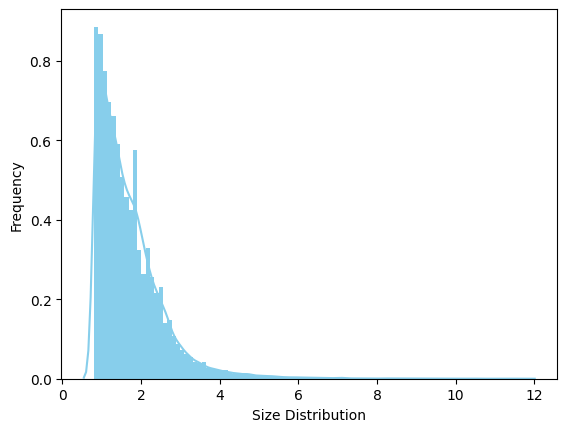

In [ ]:
data = df_work[['Size']]

ax = sns.distplot(data,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Size Distribution', ylabel='Frequency')

<ipython-input-110-290bf6beab02>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




[Text(0.5, 0, 'Asymmetry Distribution'), Text(0, 0.5, 'Frequency')]

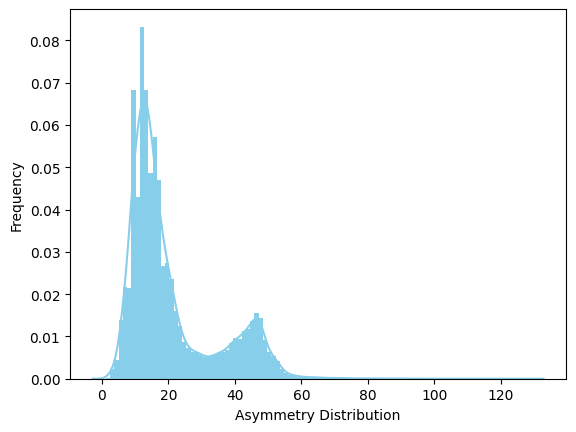

In [ ]:
data = df_work[['AF']]

ax = sns.distplot(data,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Asymmetry Distribution', ylabel='Frequency')

**MannWhitneyu test** - Non Parametic test


In [ ]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

sample_1 = df_work[['Size']]
sample_2 = df_nonwork[['Size']]

# Perform the Mann-Whitney U test
u_stat, p_value = mannwhitneyu(sample_1, sample_2)


# Apply Benjamini-Hochberg correction
pvals_corrected = multipletests( p_value, alpha=0.05, method='fdr_bh')[1]


# Print the U-statistic and p-value
print("U-statistic:", u_stat)
print("p-value:", p_value)
# Print the corrected p-values
print("Benjamini-Hochberg correction:", pvals_corrected)

U-statistic: [2.97874287e+09]
p-value: [9.44673274e-282]
Benjamini-Hochberg correction: [9.44673274e-282]


In [ ]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

sample_1 = df_work[['AF']]
sample_2 = df_nonwork[['AF']]

# Perform the Mann-Whitney U test
u_stat, p_value = mannwhitneyu(sample_1, sample_2)


# Apply Benjamini-Hochberg correction
pvals_corrected = multipletests( p_value, alpha=0.05, method='fdr_bh')[1]


# Print the U-statistic and p-value
print("U-statistic:", u_stat)
print("p-value:", p_value)
# Print the corrected p-values
print("Benjamini-Hochberg correction:", pvals_corrected)

U-statistic: [2.24133739e+09]
p-value: [0.]
Benjamini-Hochberg correction: [0.]


# **Overview of data**

Graphs and insights





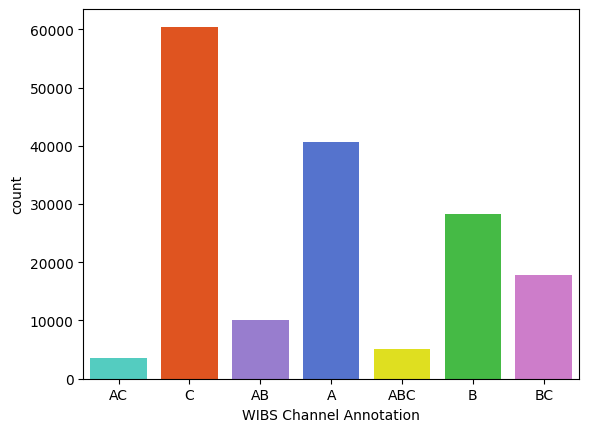

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create a dictionary that maps each category to its corresponding color
color_mapping = {
    'A': 'royalblue',
    'B': 'limegreen',
    'C': 'orangered',
    'AC': 'turquoise',
    'AB': 'mediumpurple',
    'BC': 'orchid',
    'ABC': 'yellow',
}
# Create the countplot with the custom color mapping
sns.countplot(x='WIBS Channel Annotation', data=df_full, palette=color_mapping)

# Show the plot
plt.show()

# Save the plot to a file
plt.savefig('count_plot')

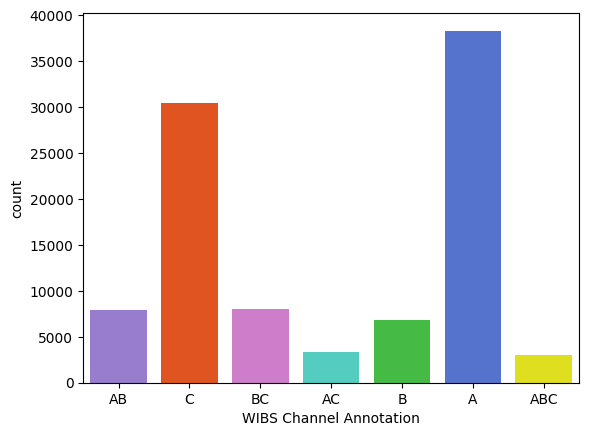

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create a dictionary that maps each category to its corresponding color
color_mapping = {
    'A': 'royalblue',
    'B': 'limegreen',
    'C': 'orangered',
    'AC': 'turquoise',
    'AB': 'mediumpurple',
    'BC': 'orchid',
    'ABC': 'yellow',
}
# Create the countplot with the custom color mapping
sns.countplot(x='WIBS Channel Annotation', data=df_work, palette=color_mapping)

# Show the plot
plt.show()

# Save the plot to a file
plt.savefig('count_plot')

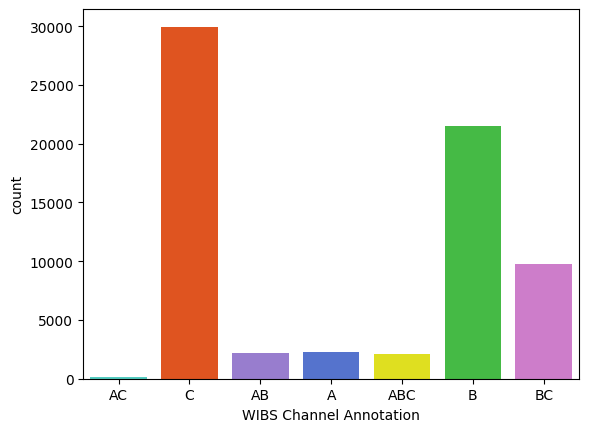

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create a dictionary that maps each category to its corresponding color
color_mapping = {
    'A': 'royalblue',
    'B': 'limegreen',
    'C': 'orangered',
    'AC': 'turquoise',
    'AB': 'mediumpurple',
    'BC': 'orchid',
    'ABC': 'yellow',
}
# Create the countplot with the custom color mapping
sns.countplot(x='WIBS Channel Annotation', data=df_nonwork, palette=color_mapping)

# Show the plot
plt.show()

# Save the plot to a file
plt.savefig('count_plot')

In [ ]:
print("Total Particle count working shifts:" "\n", df_work['WIBS Channel Annotation'].count())
print("Total Particle count non working shifts:" "\n", df_nonwork['WIBS Channel Annotation'].count())

Total Particle count working shifts:
 97715
Total Particle count non working shifts:
 67997


In [ ]:
print("Total Particle count working shifts:" "\n", df_work['WIBS Channel Annotation'].count())
category_counts = df_work['WIBS Channel Annotation'].value_counts()
mean_count = category_counts.mean()
print("Mean Particle of particles for working shifts:" "\n", mean_count)
stddev_count = category_counts.std()
print("Standard Deviation of particles for working shifts:" "\n", stddev_count)


Total Particle count working shifts:
 97715
Mean Particle of particles for working shifts:
 13959.285714285714
Standard Deviation of particles for working shifts:
 14270.871997584049


In [ ]:
print("Total Particle count non working shifts:" "\n", df_nonwork['WIBS Channel Annotation'].count())
category_counts = df_nonwork['WIBS Channel Annotation'].value_counts()
mean_count = category_counts.mean()
print("Mean Particle of particles for non working shifts:" "\n", mean_count)
stddev_count = category_counts.std()
print("Standard Deviation of particles for non working shifts:" "\n", stddev_count)


Total Particle count non working shifts:
 67997
Mean Particle of particles for non working shifts:
 9713.857142857143
Standard Deviation of particles for non working shifts:
 11609.78544775299


In [ ]:
import plotly.graph_objects as go


size_data = [df_work['Size'], df_nonwork['Size']]

# Create box plots using Plotly
fig = go.Figure()

fig.add_trace(go.Box(y=size_data[0], name='Work periods', marker_color='blue'))
fig.add_trace(go.Box(y=size_data[1], name='Non-work periods', marker_color='red'))

# Customize the plot title and labels
fig.update_layout(
    title='Boxplot of particle size',
    yaxis=dict(title='Size'),
)

# Show the plot
fig.show()

In [ ]:
print("Mean of particle size working shifts:" "\n", df_work['Size'].mean())
print("Mean of particle size non working shifts:" "\n", df_work['Size'].mean())

print("Standard Deviation of particle size working shifts:" "\n", df_work['Size'].std())
print("Standard Deviation of particle size non working shifts:" "\n", df_work['Size'].std())


Mean of particle size working shifts:
 1.695841990482526
Mean of particle size non working shifts:
 1.695841990482526
Standard Deviation of particle size working shifts:
 0.8652173243365272
Standard Deviation of particle size non working shifts:
 0.8652173243365272


In [ ]:
af_data = [df_work['AF'], df_nonwork['AF']]

# Create box plots using Plotly
fig = go.Figure()

fig.add_trace(go.Box(y=af_data[0], name='Work periods', marker_color='blue'))
fig.add_trace(go.Box(y=af_data[1], name='Non-work periods', marker_color='red'))

# Customize the plot title and labels
fig.update_layout(
    title='Boxplot of particle asymmetry factor',
    yaxis=dict(title='Asymmetry factor'),
)

# Show the plot
fig.show()

In [ ]:
print("Mean of particle asymmetry factor working shifts:" "\n", df_work['AF'].mean())
print("Mean of particle asymmetry factor non working shifts:" "\n", df_work['AF'].mean())

print("Standard Deviation of particle asymmetry factor working shifts:" "\n", df_work['AF'].std())
print("Standard Deviation of particle asymmetry factor non working shifts:" "\n", df_work['AF'].std())

Mean of particle asymmetry factor working shifts:
 20.603768684439444
Mean of particle asymmetry factor non working shifts:
 20.603768684439444
Standard Deviation of particle asymmetry factor working shifts:
 13.235058730294805
Standard Deviation of particle asymmetry factor non working shifts:
 13.235058730294805


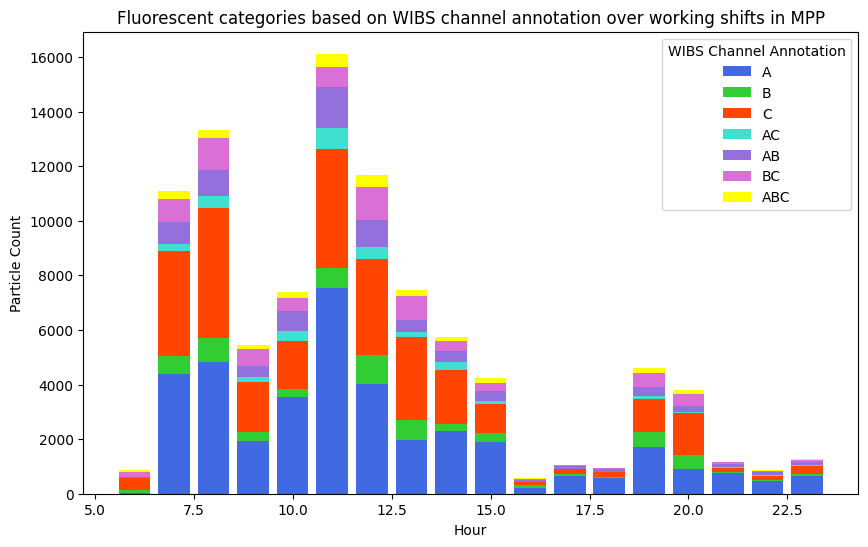

In [ ]:
color_mapping = {
    'A': 'royalblue',
    'B': 'limegreen',
    'C': 'orangered',
    'AC': 'turquoise',
    'AB': 'mediumpurple',
    'BC': 'orchid',
    'ABC': 'yellow',
}

# Grouping data by hour and count
grouped_data = df_work.groupby(['Hour', 'WIBS Channel Annotation']).size().unstack(fill_value=0)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the stacked bar chart using the grouped data
bottom = None
for category, color in color_mapping.items():
    if bottom is None:
        ax.bar(grouped_data.index, grouped_data[category], label=category, color=color)
        bottom = grouped_data[category]
    else:
        ax.bar(grouped_data.index, grouped_data[category], label=category, color=color, bottom=bottom)
        bottom += grouped_data[category]

# Set the title and axis labels
ax.set_title('Fluorescent categories based on WIBS channel annotation over working shifts in MPP')
ax.set_xlabel('Hour')
ax.set_ylabel('Particle Count')

# Add a legend
ax.legend(title='WIBS Channel Annotation', loc='upper right')

# Show the plot

In [ ]:
import plotly.graph_objects as go
color_mapping = {
    'A': 'royalblue',
    'B': 'limegreen',
    'C': 'orangered',
    'AC': 'turquoise',
    'AB': 'mediumpurple',
    'BC': 'orchid',
    'ABC': 'yellow',
}

# Grouping data by hour and count
grouped_data = df_work.groupby(['Hour', 'WIBS Channel Annotation']).size().unstack(fill_value=0)

# Create a figure object
fig = go.Figure()

# Add bar traces for each category
for category, color in color_mapping.items():
    fig.add_trace(go.Bar(x=grouped_data.index, y=grouped_data[category], name=category, marker_color=color))

# Customize the layout
fig.update_layout(
    title='Fluorescent categories based on WIBS channel annotation over working shifts in MPP',
    xaxis=dict(title='Hour'),
    yaxis=dict(title='Particle Count'),
    barmode='stack',  # This enables stacking of the bars
    legend=dict(title='WIBS Channel Annotation', x=1, y=1)  # Legend position
)

# Show the plot
fig.show()


In [ ]:
print(grouped_data.columns)

Index(['A', 'AB', 'ABC', 'AC', 'B', 'BC', 'C'], dtype='object', name='WIBS Channel Annotation')


In [ ]:
import plotly.express as px

# Grouping data by hour and count
grouped_data = df2.groupby(['Hour', 'WIBS Channel Annotation']).size().unstack(fill_value=0)

# Reset the index to convert the multi-index into columns
grouped_data = grouped_data.reset_index()

# Create the stacked bar chart using plotly express
fig = px.bar(grouped_data, x='Hour', y=[col for col in grouped_data.columns if col != 'Hour'],
             title='Fluorescent categories based on WIBS channel annotation over working shifts in MPP',
             labels={'value': 'Particle Count', 'variable': 'WIBS Channel Annotation', 'Hour': 'Hour'})

# Add a legend
fig.update_layout(legend=dict(title='WIBS Channel Annotation', yanchor="top", y=0.99, xanchor="right", x=0.01))

# Show the plot
fig.show()

# **AIR QUALITY SENSOR DATA ANALYSIS**

In [ ]:
from pathlib import Path
path = f"/drive/MyDrive/DMA_Assignment/Meat_Plant_Data/Data_collected/Air_Sensor_Data/" 

# get all files from there
csv_pattern = os.path.join(path,'*.csv')
file_list = glob.glob(csv_pattern)

#  an empty list to store the data frames
dfs = []
for file in sorted(file_list):
     # read data frame from file
    data = pd.read_csv(file,sep=';')
    # add column header into column by reset index

    dfs.append(data)
#  merges single pandas DFs into a single DF, index is refreshed 
df_air = pd.concat(dfs, ignore_index=True)


In [ ]:
df_air.head()

,Date,Time,Timestamp,PM2_5(ug/m3),AQI(US),AQI(CN),PM10(ug/m3),PM01(ug/m3),Outdoor AQI(US),Outdoor AQI(CN),Temperature(C),Temperature(F),Humidity(%RH),CO2(ppm),SGPCO2(ppm),VOC(ppb),SGPCO2LTC(ppm),VOCLTC(ppb)
0,2022/01/11,08:22:12,1641889332,39.0,110,56,39.0,24.0,0,0,9.4,48.8,87,350,-1,-202,-1,-1
1,2022/01/11,08:22:22,1641889342,40.0,112,57,40.0,25.0,0,0,9.4,48.8,87,929,-1,-202,-1,-1
2,2022/01/11,08:22:32,1641889352,42.0,117,60,42.0,27.0,0,0,9.6,49.3,87,929,-1,-202,-1,-1
3,2022/01/11,08:22:42,1641889362,44.0,122,62,44.0,29.0,0,0,9.6,49.3,87,925,-1,-202,-1,-1
4,2022/01/11,08:22:52,1641889372,47.0,129,66,47.0,31.0,0,0,9.6,49.3,87,900,-1,-202,-1,-1


In [ ]:

df_air['Timestamp'] = df_air['Date']+ ' ' +df_air['Time']
df_air['Timestamp'] = pd.to_datetime(df_air['Timestamp'])
df_air['Hour'] = df_air['Timestamp'].dt.hour
df_air['Day'] = df_air['Timestamp'].dt.day_name()


In [ ]:
df_air['Hour'].head()

0    8
1    8
2    8
3    8
4    8
Name: Hour, dtype: int64

In [ ]:
test=df_air['Hour']

In [ ]:
len(test)

1074985

In [ ]:
print(test.isnull().any())

False


In [ ]:
# # Index timestamp and order by timestamp
# df_air = df_air.sort_values(by="Hour")
df_air.set_index("Hour", inplace=True)

In [ ]:
df_air.head()

,Date,Time,Timestamp,PM2_5(ug/m3),AQI(US),AQI(CN),PM10(ug/m3),PM01(ug/m3),Outdoor AQI(US),Outdoor AQI(CN),Temperature(C),Temperature(F),Humidity(%RH),CO2(ppm),SGPCO2(ppm),VOC(ppb),SGPCO2LTC(ppm),VOCLTC(ppb),Day
Hour,,,,,,,,,,,,,,,,,,,
8,2022/01/11,08:22:12,2022-01-11 08:22:12,39.0,110,56,39.0,24.0,0,0,9.4,48.8,87,350,-1,-202,-1,-1,Tuesday
8,2022/01/11,08:22:22,2022-01-11 08:22:22,40.0,112,57,40.0,25.0,0,0,9.4,48.8,87,929,-1,-202,-1,-1,Tuesday
8,2022/01/11,08:22:32,2022-01-11 08:22:32,42.0,117,60,42.0,27.0,0,0,9.6,49.3,87,929,-1,-202,-1,-1,Tuesday
8,2022/01/11,08:22:42,2022-01-11 08:22:42,44.0,122,62,44.0,29.0,0,0,9.6,49.3,87,925,-1,-202,-1,-1,Tuesday
8,2022/01/11,08:22:52,2022-01-11 08:22:52,47.0,129,66,47.0,31.0,0,0,9.6,49.3,87,900,-1,-202,-1,-1,Tuesday


In [ ]:
df_air['Day'].unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [ ]:
df=df_air

In [ ]:
df = df[(df['Day'] != 'Saturday') & (df['Day'] !='Sunday') ]
df['Day'].unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Monday'],
      dtype=object)

In [ ]:
df_air.columns

Index(['Date', 'Time', 'Timestamp', 'PM2_5(ug/m3)', 'AQI(US)', 'AQI(CN)',
       'PM10(ug/m3)', 'PM01(ug/m3)', 'Outdoor AQI(US)', 'Outdoor AQI(CN)',
       'Temperature(C)', 'Temperature(F)', 'Humidity(%RH)', 'CO2(ppm)',
       'SGPCO2(ppm)', 'VOC(ppb)', 'SGPCO2LTC(ppm)', 'VOCLTC(ppb)', 'Day'],
      dtype='object')

**Header names to consider:** 
PM2_5,  CO2(PPM).

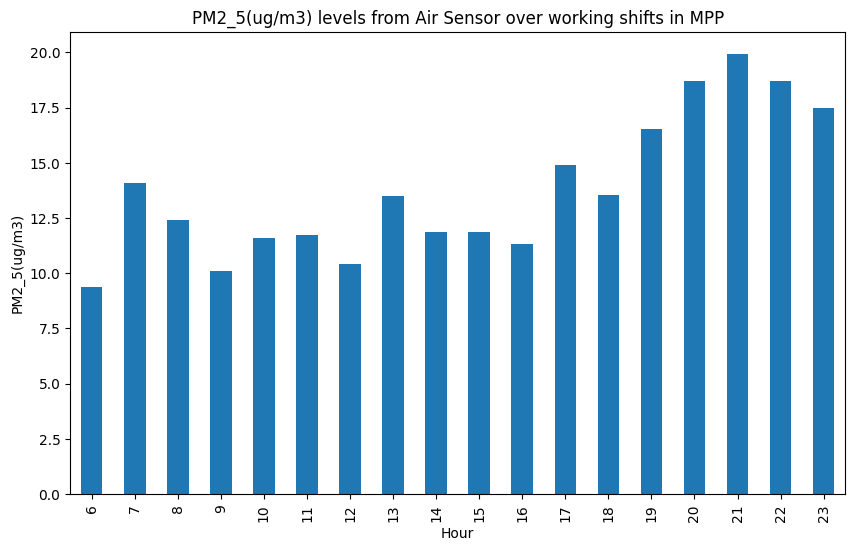

In [ ]:
workShiftCo2DF = df[(df.index >= 6)]
# Group the DataFrame by 'hour' and get the sum of the 'co2' values for each group
grouped_data = workShiftCo2DF.groupby('Hour')['PM2_5(ug/m3)'].mean()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart using the grouped data
grouped_data.plot(kind='bar', ax=ax)

# Set the title and axis labels
ax.set_title('PM2_5(ug/m3) levels from Air Sensor over working shifts in MPP')
ax.set_xlabel('Hour')
ax.set_ylabel('PM2_5(ug/m3)')

# Show the plot
plt.show()

In [ ]:
workShiftCo2DF = df[(df.index >= 6)]

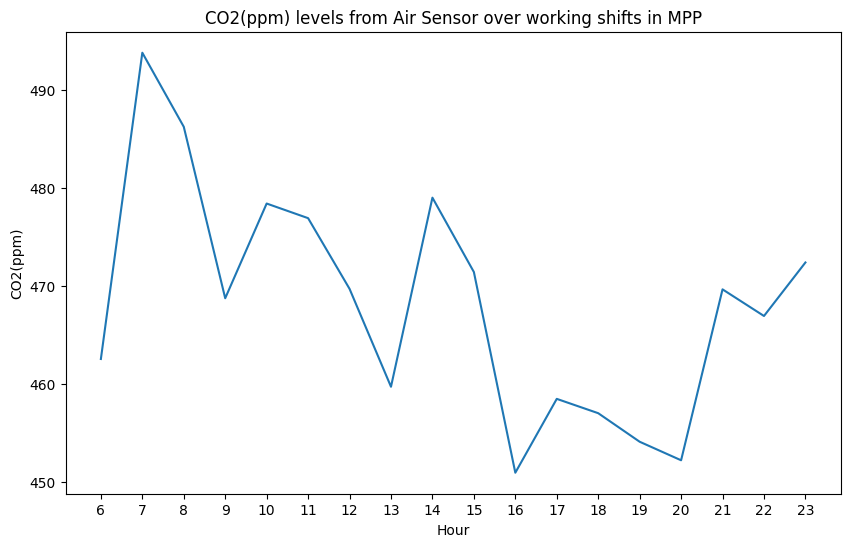

In [ ]:
# Group the DataFrame by 'hour' and get the sum of the 'co2' values for each group
grouped_dataWSCo2 = workShiftCo2DF.groupby('Hour')['CO2(ppm)'].mean()

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart using the grouped data
grouped_dataWSCo2.plot(kind='line', ax=ax)

# Set the title and axis labels
ax.set_title('CO2(ppm) levels from Air Sensor over working shifts in MPP')
ax.set_xlabel('Hour')
ax.set_ylabel('CO2(ppm)')
ax.set_xticks(range(6, 24))

# Show the plot
plt.show()

In [ ]:
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler

# Grouping data by hour and count
grouped_data = df2.groupby(['Hour', 'WIBS Channel Annotation']).size().unstack(fill_value=0)

# Reset the index to convert the multi-index into columns
grouped_data = grouped_data.reset_index()

# Create the stacked bar chart using plotly express
fig = px.bar(grouped_data, x='Hour', y=[col for col in grouped_data.columns if col != 'Hour'],
             title='Fluorescent categories based on WIBS channel annotation over working shifts in MPP VS CO2(ppm)',
             labels={'value': 'Particle Count', 'variable': 'WIBS Channel Annotation', 'Hour': 'Hour'})

# Add a legend
fig.update_layout(legend=dict(title='WIBS Channel Annotation', yanchor="top", y=0.99, xanchor="left", x=0.01))

# Group data by hour and compute the mean of CO2(ppm)
grouped_data2 = workShiftCo2DF.groupby('Hour')['CO2(ppm)'].mean()

# Rescale the CO2(ppm) data to match the scale of the particle count data
scaler = MinMaxScaler(feature_range=(grouped_data.values.min(), grouped_data.values.max()))
grouped_data2 = scaler.fit_transform(grouped_data2.values.reshape(-1, 1))

# Create a trace object for the line chart
trace = go.Scatter(x=grouped_data['Hour'], y=grouped_data2.ravel(), name='CO2(ppm)')
trace.update(line=dict(width=4, color='black'))
trace = go.Scatter(
    x=grouped_data['Hour'], y=grouped_data2.ravel(), name='CO2(ppm)',
    text=workShiftCo2DF.groupby('Hour')['CO2(ppm)'].mean(),
    hovertemplate='Hour: %{x}<br>CO2(ppm): %{text:.2f}<br>Scaled CO2(ppm): %{y:.2f}',
    line=dict(width=4, color='black'))


# Add the trace to the figure
fig.add_trace(trace)

# Show the plot
fig.show()


In [ ]:
grouped_dataWSCo2

Hour
6     462.523272
7     493.780741
8     486.223132
9     468.723127
10    478.388959
11    476.896349
12    469.683564
13    459.690895
14    478.988302
15    471.400679
16    450.916698
17    458.454105
18    456.991993
19    454.078563
20    452.187099
21    469.630525
22    466.912315
23    472.374043
Name: CO2(ppm), dtype: float64

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import plotly.graph_objs as go

# Assuming df_air and df_work have a column 'Hour' containing the hour of the day

# Group data by hour and aggregate
co2_by_hour = df_air.groupby('Hour')['CO2(ppm)'].mean().reset_index()
wibs_by_hour = df_work.groupby('Hour')['WIBS Channel Annotation'].count().reset_index()

# Merge dataframes on 'Hour'
merged_data = pd.merge(co2_by_hour, wibs_by_hour, on='Hour')

# Calculate the Spearman Rank-Order Correlation
correlation_coefficient, p_value = spearmanr(merged_data['CO2(ppm)'], merged_data['WIBS Channel Annotation'])

print("Spearman correlation coefficient:", correlation_coefficient)
print("p-value:", p_value)

# Create a scatter plot with Plotly
fig = go.Figure(data=go.Scatter(x=merged_data['CO2(ppm)'], y=merged_data['WIBS Channel Annotation'], mode='markers'))

# Customize the plot title and labels
fig.update_layout(
    title=f'Spearman Correlation between CO2(ppm) and WIBS Channel Annotation (rho: {correlation_coefficient:.2f})',
    xaxis=dict(title='CO2(ppm)'),
    yaxis=dict(title='WIBS Channel Annotation Count'),

)

# Show the plot
fig.show()


Spearman correlation coefficient: 0.6594427244582043
p-value: 0.0029088627228155838
